# Analyzing Food Webs through Redundant and Funcional Connections

by Elias Gabriel and Shirin Kuppusamy

In [1]:
%matplotlib inline

# Import all the packages we might use
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

### Importing the Data

Using the data we found in our second references paper, we create a Panda's DataFrame. Each species is represented by a number and each entry shows what percentage of the column species' diet is composed of the corresponding prey.

In [2]:
# Import the predetory matrix from the Yodzis paper
web = pd.read_csv('../data/benguela_yodzis.csv', index_col='prey', header=0).fillna(0)
web.head()

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
prey,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,98.8,0.0,30.6,45.0,60.0,25.0,5.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,29.7,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.2,22.0,1.2,8.8,0.0,1.2,0.0,0.6,9.6,8.0
5,0.0,0.0,0.0,0.0,29.7,45.0,0.0,25.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Using that information, we create a directed graph, where edges point from prey to predetor.

/home/egabriel/miniconda3/envs/FoodWeb/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/egabriel/miniconda3/envs/FoodWeb/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


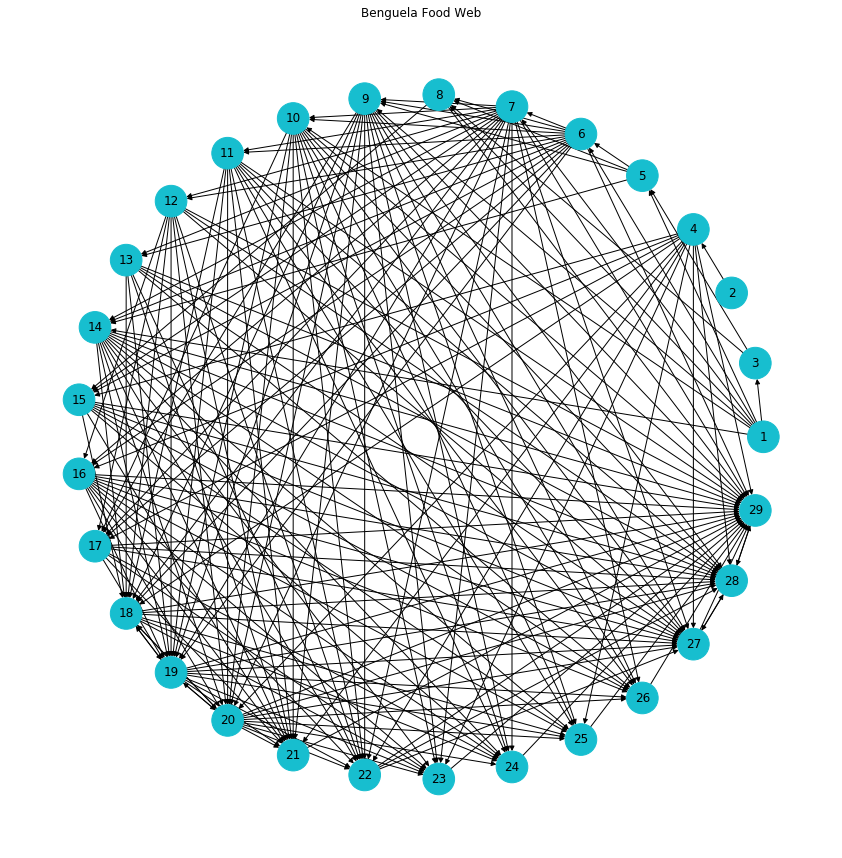

In [3]:
# Created a directed graph to represent predetor vs. prey behaviors
G = nx.DiGraph()

# Add all of connections and their weights
for pred, preys in web.iteritems():
    for prey, weight in preys.iteritems():
        if weight > 0: # If the weight is not 0, then its a connection that exists
            G.add_edge(prey, int(pred), weight=(weight / 100))

# Set the figure size so the graph is slightly more legible
plt.rcParams["figure.figsize"] = (11.5, 11.5)

# Draw the graph circularly
colors =['C9'] * len(G)
nx.draw_circular(G, node_color=colors, node_size=1000, with_labels=True)
plt.title("Benguela Food Web");

For verification, we check if the number of nodes in our graph is equal to the number of species in our imported food web.

In [4]:
print(len(G) == len(web)) # Verify that we made the right number of nodes
print(len(G.edges())) # Check that we made the right number of edges

True
202


### Experimental Replication

We start by implementing an algorithm to remove nodes from a foodweb based on their degree. This has historically been the apporch used in analzing the ecological importance of a species in a particular food web<sup>[1]</sup>.

In [14]:
def targeted_removal(G, priorities, inplace=False):
    """
    Sequentially removes nodes from G in order of highest priority to lowest, where `priorities`
    is a pre-sorted list of nodes. If `inplace` is set to True, the provided graph will be altered.
    Results from the targeted removal are returned in a Pandas series, where the index is the
    number of nodes removed and the value is the percentage of extinct species at that point.
    """
    # Unless we specifically ask, don't remove nodes the graph we give it
    if not inplace:
        G = G.copy()

    # Create a Series object with the capacity of the graph
    results = pd.Series(len(G))
    # With no nodes removed, nothing has gone exitinct yet
    results[0] = 0
    # Save the initial length of the graph
    starting_len = len(G.nodes())
    
    for i, node in enumerate(priorities):
        # We need this check in the case a node we haven't iterated over yet has died off
        # in a secondary extinction event.
        if node in G.nodes():
            G.remove_node(node)
            
            # Check for new orphans and remove them from the graph. This represents
            # secondary extinction events, where the extinction of one species
            # cascades into the extinction of another because of a lack of prey.
            G.remove_nodes_from((n for n in tuple(G) if len(list(G.predecessors(n))) == 0))

            # Caluclate the percentage of nodes that have gone extinct for this step
            results[((i + 1) / starting_len) * 100] = (1 - (len(G.nodes()) / starting_len)) * 100
            
    return results

def targeted_removal_centrality(G, inplace=False):
    """
    Performs a targeted removal of nodes based on their centrality values. That is,
    the node with the highest number of connections (highest degree) will be removed
    at each step.
    """
    # Compute the centrality values for all the nodes in G, which is just each node's normalized
    # number of connections
    centrals = nx.degree_centrality(G)
    # Sort the nodes by their centralities in DESC order
    important = sorted(centrals, key=centrals.get, reverse=True)
    return targeted_removal(G, important, inplace=inplace)

To see the gravity of this approch, we run a targeted removal of central nodes on the food network we imported.

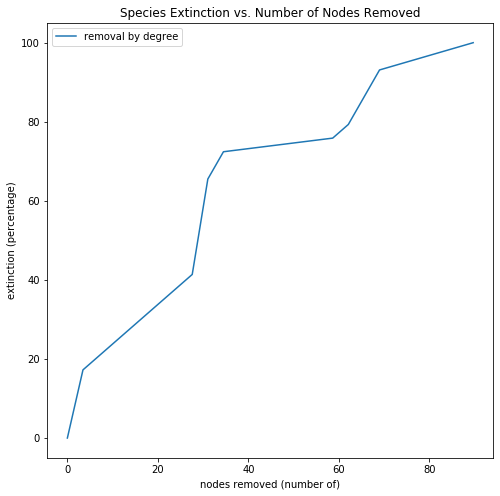

In [6]:
# Plot and label the results
results = targeted_removal_centrality(G)
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(results, label='removal by degree')
plt.title("Species Extinction vs. Number of Nodes Removed")
plt.xlabel("nodes removed (number of)")
plt.ylabel("extinction (percentage)")
plt.legend();

As we expect, the more nodes we remove from the graph the higher the percentage of the graph goes extinct. Occasionally we see a non-linear spike, which indicates that in a given iteration more species died than were explicitly removed. Given we removed nodes with high degrees of connectedness, its unsurprising to see that removal of some species causes secondary extinction events in relying predators.

The paper we are replicating attempts to show the effect of functional vs. redundant connections on a food network. In the context of our experiment, a functional node is one that will cause ripple extinctions if removed. To find functional connections, we implement an algorithm to first find the set of immediate dominators for each node in the graph. The immediate dominators of a node `n` are the nodes through which a path must travel in order to get from the root of the network to `n`.

In [1]:
import collections

def imdom(G, r):
    """
    Finds the immediate multiple-node dominators for every node v in the provided graph,
    starting at the provided root `r`. It is a direct implementation of the algorithm detailed
    by H. Christensen on pg. 18 of:
    
    http://www.cs.au.dk/~gerth/advising/thesis/henrik-knakkegaard-christensen.pdf
    """
    # Create a set of all the nodes in the graph
    V = set(G.nodes())
    # Create a single-node set of the provided root
    root = {r}
    imdom = { v: V for v in V - root }
    imdom[r] = root    
    prev = None

    # Continue to find all the immediate dominators until no changes have been made
    while prev != imdom:
        prev = imdom # Set the current state of imdom

        # For every node in the graph except the root
        for v in V - root:
            # Find all the predecessors of the current node
            preds = G.predecessors(v)
            # Set the imdoms of v to the intersection of all the sets of all the immediadte
            # dominators of each predecessor, and then add the current node
            imdom[v] = {v}.union(V.intersection(*[imdom[q] for q in preds]))
    
    return imdom

def imdoms(G):
    """
    Finds all the immediate dominators for every node in the graph. Because food webs might
    contain more than a single source of energy (i.e. multiple plant species or autotrophs), the
    immediate dominators for each node are found for  every root, and then combined and
    returned.
    """
    # Create a defaultdict with a default value of a set so we don't have to bother checking and
    # create an empty one whenever we try and access a node
    idoms = collections.defaultdict(set)
    
    # For every node in G
    for r in G:
        # Check to see if it has no predecessors, which would mean that it has no prey and thus
        # is a source of energy for the food web
        if len(list(G.predecessors(r))) == 0: 
            # Get all the imdoms for the graph using that node as a root
            for n, ws in imdom(G, r).items():
                idoms[n].update(ws)
    
    return idoms

Once we can find each nodes set of immedite dominators, we can easily find the set of all functional and redundant edges in the graph.

In [8]:
def find_functional(G):
    """
    Find all the functional connections in the graph `G`. Functional connections
    are edges between nodes and their immediate dominators, meaning they
    are essential for the transfer of energy from the autotrophic root species.
    """
    functional = { (w, v) for v, ws in imdoms(G).items() for w in ws if G.has_edge(w, v) }    
    return functional

def find_redundant(G):
    """
    Find all the redundant connections in the graph `G`. Redundant connections
    are all the edges in a graph that are not functional.
    """
    return G.edges() - find_functional(G)

To test the algorithm, we implement a simple example model provided in the Allesina paper.

/home/egabriel/miniconda3/envs/FoodWeb/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


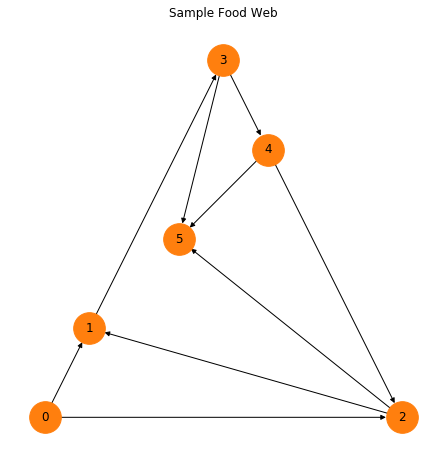

In [9]:
# Creates a graph to test the algorithms below
T = nx.DiGraph()

T.add_edge(0, 1)
T.add_edge(0, 2)
T.add_edge(1, 3)
T.add_edge(3, 4)
T.add_edge(3, 5)
T.add_edge(2, 5)

T.add_edge(4, 5)
T.add_edge(4, 2)
T.add_edge(2, 1)
T.add_edge(5, 5) # This doesn't plot, but it is there

plt.rcParams["figure.figsize"] = (6, 6)
nx.draw_planar(T, node_color='C1', node_size=1000, with_labels=True)
plt.title("Sample Food Web");

We then remove all the redundant connections and compare the graphs.

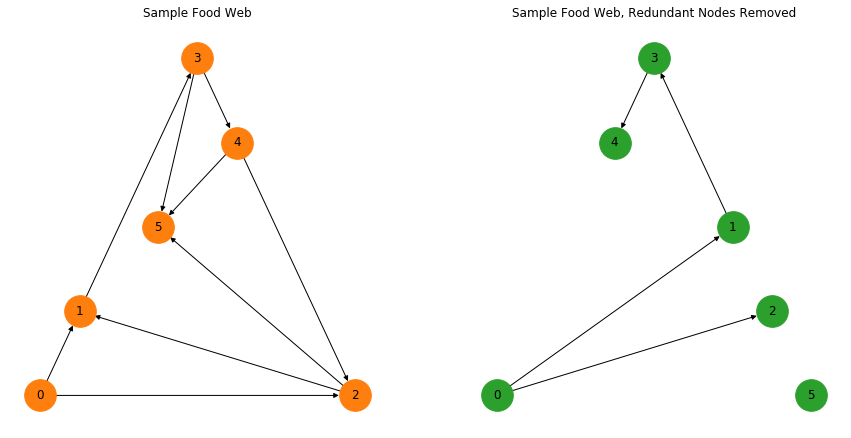

In [10]:
# Set the figure size so we can see what we're doing
plt.rcParams["figure.figsize"] = (15, 7.5)

# Define subplots so we can compare networks easily
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
# Plot the given test graph
nx.draw_planar(T, node_color='C1', node_size=1000, with_labels=True)
plt.title("Sample Food Web")

plt.subplot(1, 2, 2)
# Copy the graph so that we don't remove edges from the template
U = T.copy()
# Remove all the redundant connections in the graph
U.remove_edges_from(find_redundant(U))
# Draw the graph without redundant connections
nx.draw_planar(U, node_color='C2', node_size=1000, with_labels=True)
plt.title("Sample Food Web, Redundant Nodes Removed");

We do the same for our foodweb and plot the new network to see the difference.

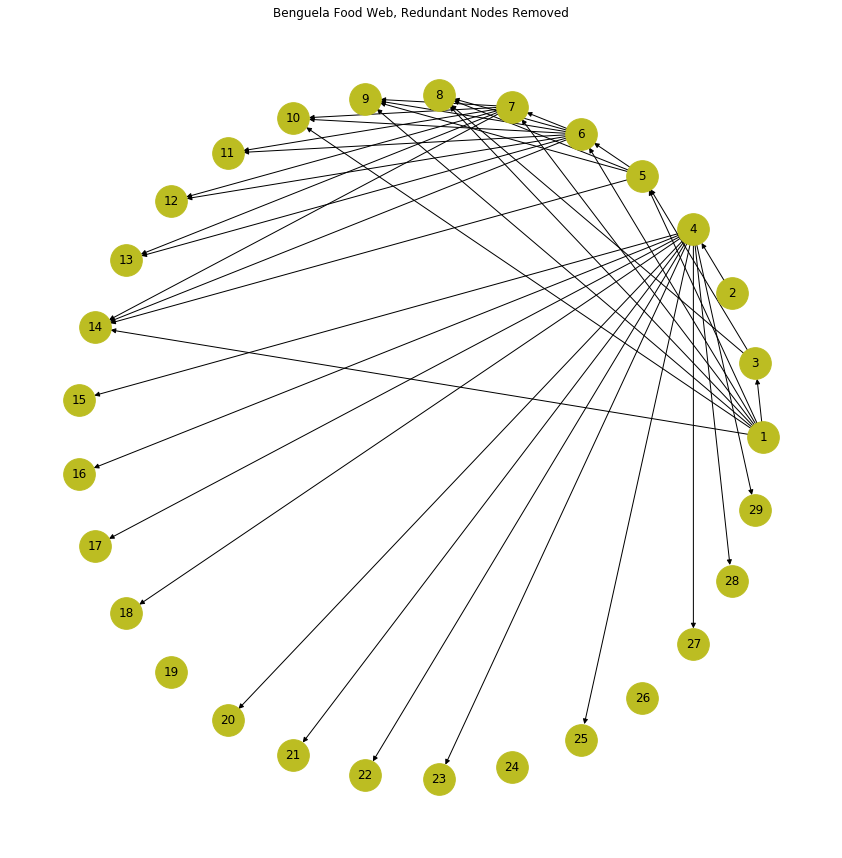

In [11]:
# Set the figure size like above
plt.figure(figsize=(11.5, 11.5))
# Copy, remove the redundant connections, and plot the resultant graph
# using the data imported from the cited foodweb
U = G.copy()
U.remove_edges_from(find_redundant(U))
nx.draw_circular(U, node_color='C8', node_size=1000, with_labels=True)
plt.title("Benguela Food Web, Redundant Nodes Removed");

Using the same approch as we used in removal by degree centrality, we remove nodes based on their number of functional connections.

In [12]:
def targeted_removal_functional(G, inplace=False):
    """
    Performs a targeted removal of nodes based on their functional degree. That is,
    the node with the highest number of functional connections will be removed
    at each step.
    """
    # Compute the immediate dominator tree for every node at every root
    idoms = imdoms(G)
    # Sort the nodes by their number of functional connections in DESC order
    important = sorted(idoms, key=lambda k: len(idoms[k]), reverse=True)
    return targeted_removal(G, important, inplace=inplace)

And we plot the results to see what it looks like.

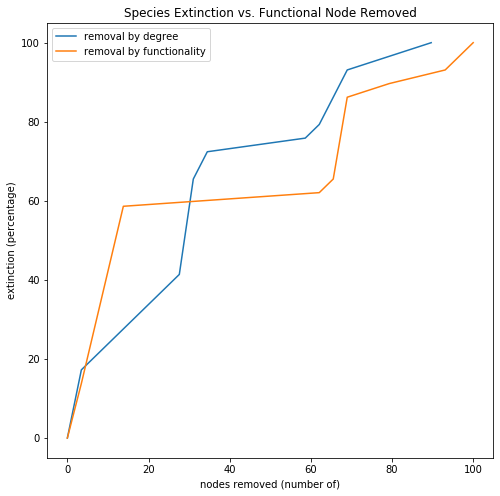

In [13]:
# Plot and label the results of degree-first and functional-first removal
results = targeted_removal_centrality(G)
results2 = targeted_removal_functional(G)

plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(results, label='removal by degree')
plt.plot(results2, label='removal by functionality')
plt.title("Species Extinction vs. Functional Node Removed")
plt.xlabel("nodes removed (number of)")
plt.ylabel("extinction (percentage)")
plt.legend();